# Plot RV curves

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pylab
import matplotlib.pyplot as plt
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)

In [3]:
import jax
import jax.numpy as jnp
from jax import lax

jax.config.update("jax_enable_x64", True)

# --------- Newton で E を解く（配列 M, スカラー e）---------
def _solve_E(M, e, tol=1e-10, max_iters=64):
    E0 = M + 0.85 * jnp.sign(jnp.sin(M)) * e  # 初期値

    def f(E):   # F(E,M,e)=0 の左辺
        return E - e * jnp.sin(E) - M

    def fp(E):  # ∂F/∂E
        return 1.0 - e * jnp.cos(E)

    def body(state):
        E, diff, it = state
        En = E - f(E) / fp(E)
        d  = jnp.max(jnp.abs(En - E))   # 停止判定はスカラー
        return (En, d, it + 1)

    def cond(state):
        _, diff, it = state
        return jnp.logical_and(diff > tol, it < max_iters)

    E, _, _ = lax.while_loop(cond, body, (E0, jnp.inf, 0))
    return jnp.mod(E, 2*jnp.pi)

@jax.custom_vjp
def ecc_anomaly(M, e):
    """Solve M = E - e*sin(E) for E.
       Assumes: M is array-like, e is scalar."""
    return _solve_E(M, e)

def _fwd(M, e):
    E = _solve_E(M, e)
    return E, (E, e)  # 逆伝播に使うのは (E,e)

def _bwd(res, gE):
    E, e = res
    denom = 1.0 - e * jnp.cos(E)
    # 近接特異の軽いガード（必要なら調整/削除）
    denom = jnp.where(jnp.abs(denom) < 1e-15, jnp.sign(denom) * 1e-15, denom)

    # 陰関数定理：dE/dM = 1/denom,  dE/de = sin(E)/denom
    dE_dM = 1.0 / denom            # shape = M.shape
    dE_de = jnp.sin(E) / denom     # shape = M.shape

    gM = gE * dE_dM                # M と同形
    ge = jnp.sum(gE * dE_de)       # e はスカラーなので要素和で縮約
    return (gM, ge)

ecc_anomaly.defvjp(_fwd, _bwd)



$F(E,M,e) = E - e \sin{E} - M = 0$


- Implicit Function Theorum

$\dfrac{\partial E}{\partial x} = - \dfrac{ \partial F/ \partial x }{\partial F / \partial E}$


- partial derivative F by E

$\dfrac{\partial F}{\partial E} = 1 - e \cos{E}$



$\dfrac{\partial E}{\partial M} = - \dfrac{ \partial F/ \partial M }{\partial F / \partial E} = \dfrac{1}{1 - e \cos{E}}$

$\dfrac{\partial E}{\partial e} = - \dfrac{ \partial F/ \partial e }{\partial F / \partial E} = \dfrac{\sin{E}}{1 - e \cos{E}}$





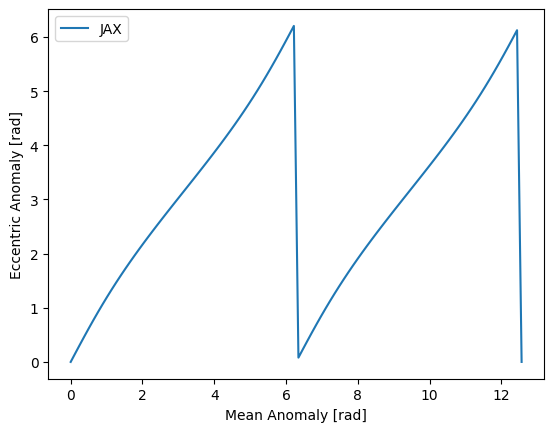

In [4]:


e = 0.2 
mean_anomaly = jnp.linspace(0, 4 * jnp.pi, 100)

plt.plot(mean_anomaly, ecc_anomaly(mean_anomaly, e), label="JAX")
plt.xlabel("Mean Anomaly [rad]")
plt.ylabel("Eccentric Anomaly [rad]")
plt.legend()


In [5]:
import jax
import jax.numpy as jnp


# -------------------------------------------------
# JAX‑compatible implementation
# -------------------------------------------------



@jax.jit
def get_rv(e: float, omega: float, mean_anomaly: jnp.ndarray) -> jnp.ndarray:
    """Compute radial‑velocity model without explicit Python loops.

    Args:
        e (float): eccentricity (0 ≤ e < 1).
        omega (float): argument of periastron [rad].
        mean_anomaly (jnp.ndarray): mean anomaly [rad], shape (num,).
    Returns:
        model (jnp.ndarray): RV model on the same grid, shape (num,).
    """
    vp = 0.0
    Ksini = 1.0

    # Mean‑anomaly grid
    
    # Vectorised solution of Kepler's equation
    E = ecc_anomaly(mean_anomaly, e)     # shape (num,)

    # True‑anomaly related quantities
    cosE = jnp.cos(E)
    cosf = (-cosE + e) / (-1.0 + cosE * e)

    sinf_base = jnp.sqrt((1.0 - cosE**2) * (1.0 - e**2)) / (-1.0 + cosE * e)
    ## sign flip depending on E
    sinf = jnp.where(E < jnp.pi, -sinf_base, sinf_base)
    #sinf = sinf_base


    # Projected cosine term
    cosfpo = cosf * jnp.cos(omega) - sinf * jnp.sin(omega)

    # RV curve
    face = 1.0 / jnp.sqrt(1.0 - e * e)
    model = vp + Ksini * face * (cosfpo + e * jnp.cos(omega))

    return model


In [6]:
def conic(e,omega):
    t=np.linspace(-2*np.pi,2*np.pi,1000)
    f=t-omega
    r=(1-e**2)/(1+e*np.cos(f))
    x=r*np.cos(t)
    y=r*np.sin(t)
    return x,y

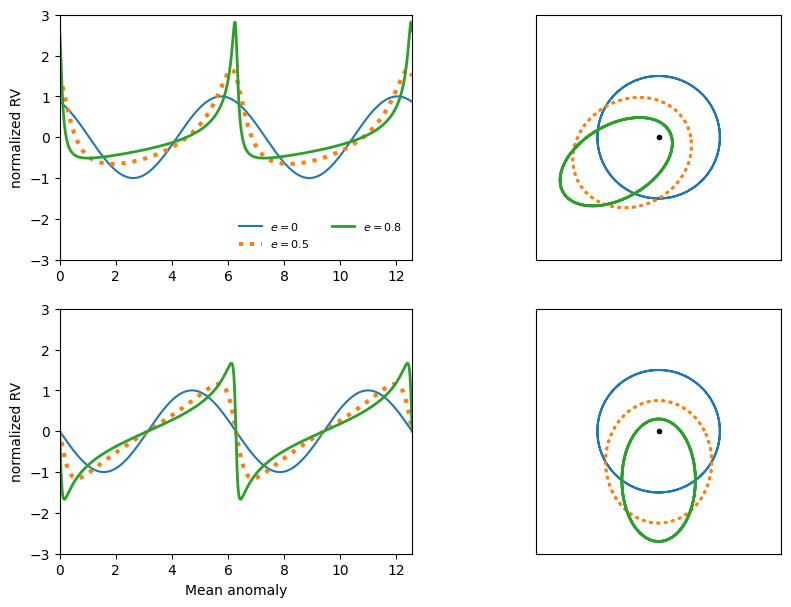

In [7]:
M = jnp.linspace(0.0, 4.0 * jnp.pi, 1000)


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(221)
pylab.ylim(-3, 3)
pylab.xlim(0.0, 4 * np.pi)
model = get_rv(0.0, np.pi / 6, M)
ax.plot(M, model, color="C0")
model = get_rv(0.5, np.pi / 6, M)
ax.plot(M, model, color="C1", ls="dotted", lw=3)
model = get_rv(0.8, np.pi / 6, M)
ax.plot(M, model, color="C2", lw=2)
plt.legend(
    ["$e=0$", "$e=0.5$", "$e=0.8$"],
    loc="lower right",
    prop={"size": 8},
    frameon=False,
    ncol=2,
)
#
pylab.ylabel("normalized RV")

ax = fig.add_subplot(223)
pylab.ylim(-3, 3)
pylab.xlim(0.0, 4 * np.pi)
model = get_rv(0.0, np.pi / 2, M)
ax.plot(M, model, color="C0")
model = get_rv(0.5, np.pi / 2, M)
ax.plot(M, model, color="C1", ls="dotted", lw=3)
model = get_rv(0.8, np.pi / 2, M)
ax.plot(M, model, color="C2", lw=2)
pylab.ylabel("normalized RV")
pylab.xlabel("Mean anomaly")

ax = fig.add_subplot(222)
pylab.ylim(-2, 2)
pylab.xlim(-2, 2)
x, y = conic(0.0, np.pi / 6)
ax.plot(x, y, color="C0")
x, y = conic(0.5, np.pi / 6)
ax.plot(x, y, color="C1", ls="dotted", lw=2)
x, y = conic(0.8, np.pi / 6)
ax.plot([0], [0], ".", color="black", lw=2)
ax.plot(x, y, color="C2", lw=2)
ax.set_aspect(1.0 / ax.get_data_ratio())
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

ax = fig.add_subplot(224)
pylab.ylim(-2, 2)
pylab.xlim(-2, 2)
x, y = conic(0.0, np.pi / 2)
ax.plot(x, y, color="C0")
x, y = conic(0.5, np.pi / 2)
ax.plot(x, y, color="C1", ls="dotted", lw=2)
x, y = conic(0.8, np.pi / 2)
ax.plot(x, y, color="C2", lw=2)
ax.plot([0], [0], ".", color="black")
ax.set_aspect(1.0 / ax.get_data_ratio())
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.show()

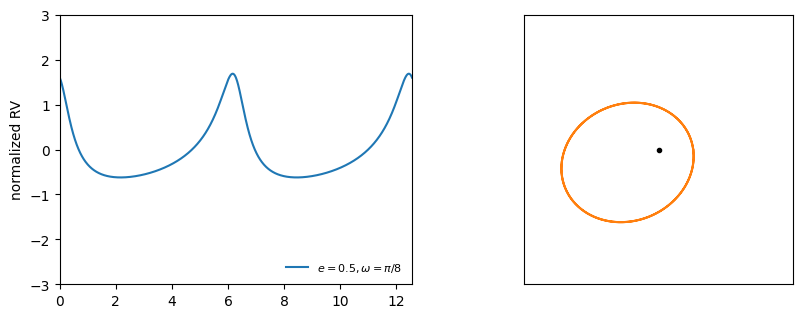

In [8]:
fig = plt.figure(figsize=(10, 3.5))
ax = fig.add_subplot(121)
pylab.ylim(-3, 3)
pylab.xlim(0.0, 4 * np.pi)
model = get_rv(0.5, np.pi / 8, M)
ax.plot(M, model, color="C0")

plt.legend(
    ["$e=0.5, \omega=\pi/8$"],
    loc="lower right",
    prop={"size": 8},
    frameon=False,
    ncol=2,
)
#
pylab.ylabel("normalized RV")

ax = fig.add_subplot(122)
pylab.ylim(-2, 2)
pylab.xlim(-2, 2)
x, y = conic(0.5, np.pi / 8)
ax.plot(x, y, color="C1")
ax.plot([0], [0], ".", color="black")
ax.set_aspect(1.0 / ax.get_data_ratio())
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.show()

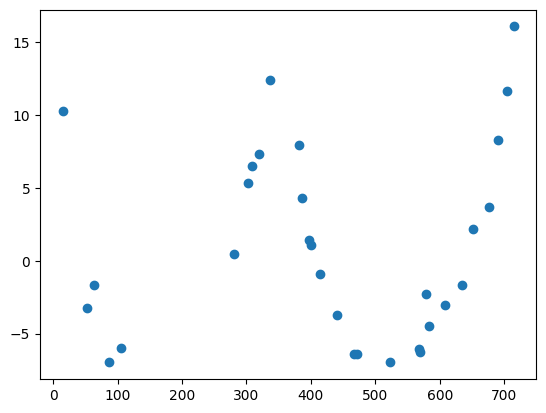

In [9]:
np.random.seed(0)

ein = 0.5
omegain = np.pi / 8
main = np.random.uniform(0, 4 * np.pi, 30)
main = np.sort(main)
mock_model = get_rv(ein, omegain, main)
Kpin = 10 #cm/s
Vsys = 0.0
noise_std = 1.0
mock_rv = Kpin*mock_model + Vsys + np.random.normal(0, noise_std, len(mock_model))

P = 365.0 #day
tobs = P*main/(2*np.pi)

plt.plot(tobs, mock_rv, "o", color="C0", label="mock data")

In [10]:


def model_rv(e, omega, Kp, Vsys, P, T0):
    ma = (tobs - T0) * (2 * jnp.pi) / P
    nomralized_rv = get_rv(e, omega, ma)

    return Kp * nomralized_rv + Vsys



In [11]:
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
import numpyro
from jax import random

/home/kawahara/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm-4.66.5-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def model_prob(rv):

    e = numpyro.sample("e", dist.Uniform(0.0, 1.0))
    omega = numpyro.sample("omega", dist.Uniform(0.0, 2 * jnp.pi))
    Kp = numpyro.sample("Kp", dist.Uniform(5.0, 15.0))
    Vsys = numpyro.sample("Vsys", dist.Uniform(-1.0, 1.0))
    P = numpyro.sample("P", dist.Uniform(300.0, 400.0))
    T0 = numpyro.sample("T0", dist.Uniform(-10.0, 10.0))

    mu = model_rv(e, omega, Kp, Vsys, P, T0)

    # noise model parameters priors
    sigmain = numpyro.sample("sigmain", dist.Exponential(1.0))

    numpyro.sample("rv", dist.Normal(mu, sigmain), obs=rv)

In [13]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 500, 1000
#kernel = NUTS(model_prob, forward_mode_differentiation=True)
kernel = NUTS(model_prob, forward_mode_differentiation=False)

In [14]:
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, rv=mock_rv)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:21<00:00, 68.66it/s, 15 steps of size 1.76e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kp      9.90      0.45      9.87      9.16     10.63    407.38      1.00
         P    364.76      2.30    364.84    361.02    368.43    495.41      1.00
        T0     -2.33      3.36     -2.40     -7.67      3.27    430.15      1.00
      Vsys     -0.22      0.29     -0.23     -0.73      0.21    476.71      1.00
         e      0.47      0.04      0.47      0.41      0.52    465.64      1.00
     omega      0.34      0.07      0.34      0.24      0.45    372.86      1.00
   sigmain      1.25      0.19      1.22      0.94      1.54    632.53      1.00

Number of divergences: 0


In [15]:
from numpyro.diagnostics import hpdi
from numpyro.infer import Predictive
import jax.numpy as jnp


In [16]:
# SAMPLING
posterior_sample = mcmc.get_samples()
pred = Predictive(model_prob, posterior_sample, return_sites=['rv'])
predictions = pred(rng_key_, rv=None)
median_mu1 = jnp.median(predictions['rv'], axis=0)
hpdi_mu1 = hpdi(predictions['rv'], 0.9)

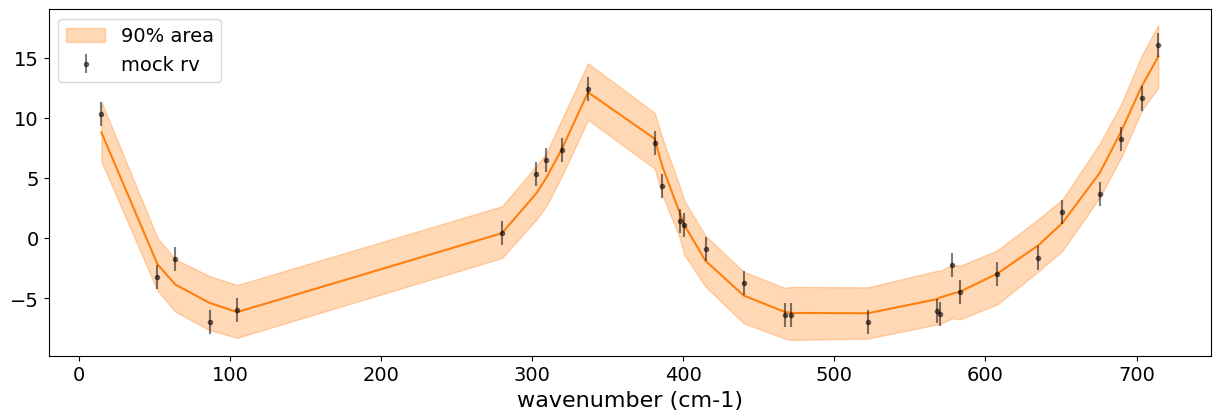

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4.5))
ax.plot(tobs, median_mu1, color='C1')
ax.fill_between(tobs,
                hpdi_mu1[0],
                hpdi_mu1[1],
                alpha=0.3,
                interpolate=True,
                color='C1',
                label='90% area')
ax.errorbar(tobs, mock_rv, 1.0*np.ones_like(tobs), fmt=".", label="mock rv", color="black",alpha=0.5)
plt.xlabel('wavenumber (cm-1)', fontsize=16)
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.show()


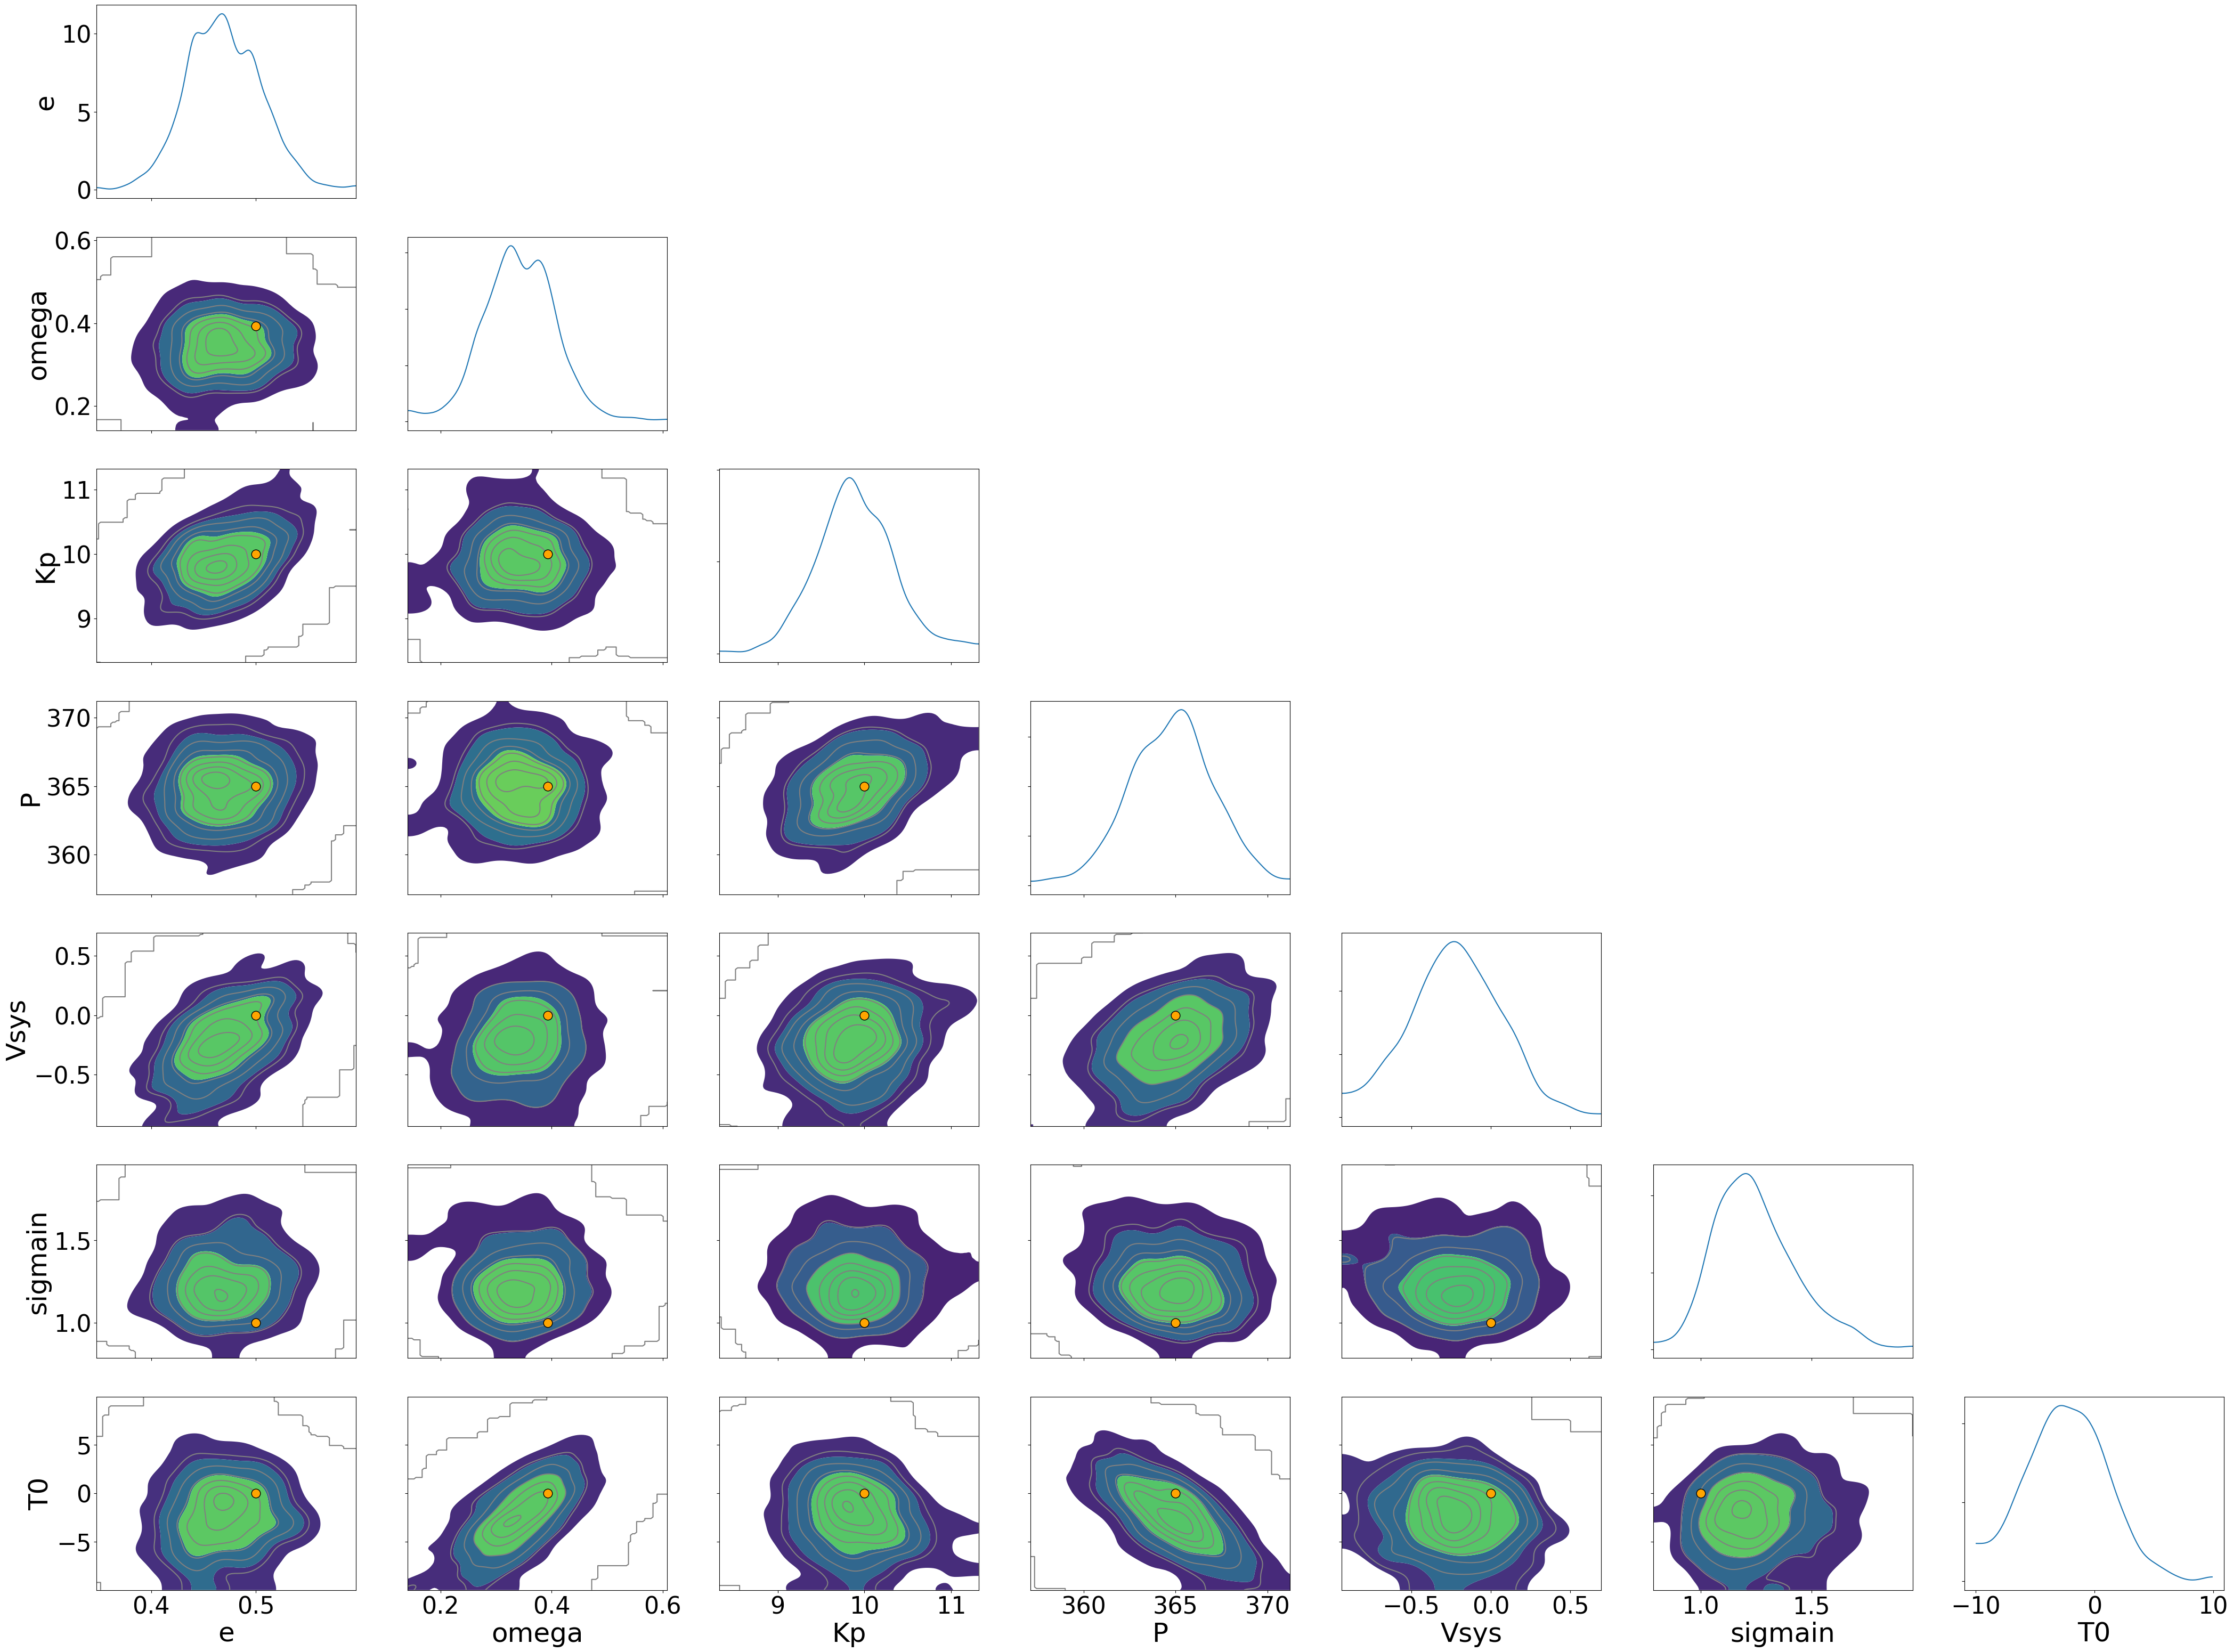

In [27]:


import arviz

pararr = ["e", "omega", "Kp", "P", "Vsys", "sigmain", "T0"]
arviz.plot_pair(
    arviz.from_numpyro(mcmc),
    kind="kde",
    marginals=True,
    var_names=pararr,
    divergences=True,
    reference_values={
        "e": ein,
        "omega": omegain,
        "Kp": Kpin,
        "P": P,
        "Vsys": Vsys,
        "sigmain": noise_std,
        "T0": 0.0,
    },
    reference_values_kwargs={
        "marker": "o",          # マーカー形状
        "markersize": 12,       # ← 's' ではなく markersize
        "linestyle": "None",    # 線を引かず点だけ
        "color": "orange",
        # 必要なら：
        # "markerfacecolor": "none",
        # "markeredgecolor": "red",
        # "markeredgewidth": 1.5,
        # "alpha": 0.8,
    },
    textsize=32
)

plt.show()

In [19]:
np.savetxt("rvmock.csv",np.array([tobs,mock_rv]).T,delimiter=",",header="tobs (day), rv (cm/s)")
